In [ ]:
!unzip alzheimer.zip && rm alzheimer.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# STEP 1: Install required packages
!pip install keras-tuner tensorflow tqdm --quiet

# STEP 2: Import libraries
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# STEP 3: Define paths
input_root = '/content/Alzheimer_s Dataset/train'
output_root = '/content/alzheimer_seg'
os.makedirs(output_root, exist_ok=True)


# STEP 4: Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    image_array = np.array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image.size

# STEP 5: Dummy segmentation model (replace this with real model later)
def dummy_segmentation_model(image_tensor):
    # Simple green channel threshold for demo purposes
    mask = (image_tensor[0][:, :, 1] > 0.5).astype(np.uint8) * 255
    return mask

# Optional: Load real segmentation model here (U-Net or custom model)
# model = tf.keras.models.load_model('/content/unet_model.h5')

# STEP 6: Iterate over all class folders
for class_name in os.listdir(input_root):
    class_input_path = os.path.join(input_root, class_name)

    # Skip non-directories like .DS_Store
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_root, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    # STEP 7: Process each image
    for img_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_input_path, img_name)

        # Skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:
            img_tensor, original_size = preprocess_image(img_path)

            # Real model prediction (uncomment when using real model)
            # prediction = model.predict(img_tensor)
            # mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255

            # Dummy segmentation
            mask = dummy_segmentation_model(img_tensor)

            # Resize mask back to original image size and save
            mask_image = Image.fromarray(mask).resize(original_size)
            mask_image.save(os.path.join(class_output_path, img_name))

        except Exception as e:
            print(f"❌ Failed to process {img_path}: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


Processing NonDemented: 100%|██████████| 2560/2560 [00:05<00:00, 460.91it/s]


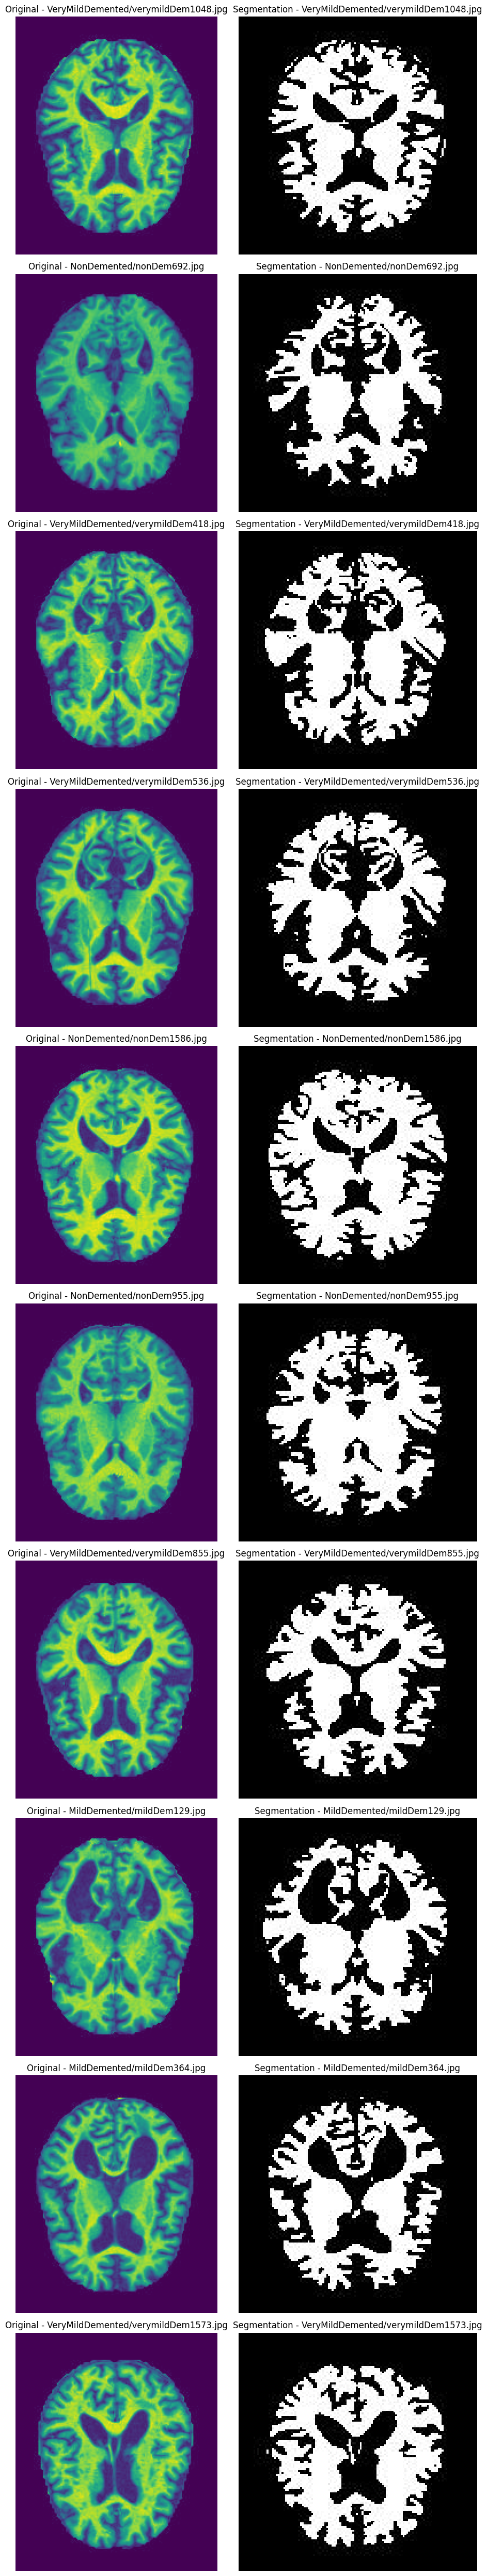

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths
original_path = '/content/Alzheimer_s Dataset/train'
segmented_path = '/content/alzheimer_seg'

# How many samples to show
num_samples = 10

# Collect valid (class, image) pairs
samples = []
for class_name in os.listdir(original_path):
    class_orig = os.path.join(original_path, class_name)
    class_seg = os.path.join(segmented_path, class_name)

    if not os.path.isdir(class_orig) or not os.path.isdir(class_seg):
        continue

    images = [f for f in os.listdir(class_orig) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img in images:
        if os.path.exists(os.path.join(class_seg, img)):
            samples.append((class_name, img))

# Randomly select samples
selected_samples = random.sample(samples, min(num_samples, len(samples)))

# Plotting
fig, axes = plt.subplots(len(selected_samples), 2, figsize=(10, 5 * len(selected_samples)))

for i, (cls, img_name) in enumerate(selected_samples):
    orig_img = Image.open(os.path.join(original_path, cls, img_name))
    seg_img = Image.open(os.path.join(segmented_path, cls, img_name))

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original - {cls}/{img_name}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(seg_img, cmap='gray')
    axes[i, 1].set_title(f"Segmentation - {cls}/{img_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# STEP 1: Install and import libraries
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# STEP 2: Define dataset paths
dataset_path = '/content/alzheimer_seg'

In [ ]:
# iamge params
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32
num_classes = len(os.listdir(dataset_path))

In [ ]:
# create train and validation generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


Matthews Correlation Coefficient: 0.393


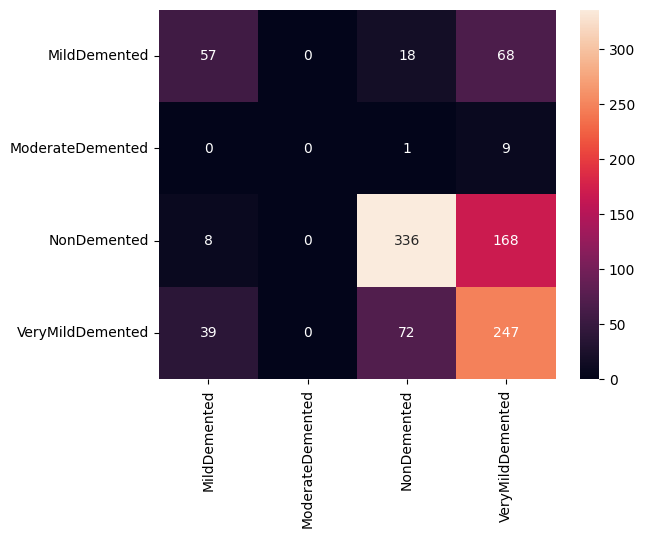

In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import seaborn as sns

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Matthews Correlation Coefficient (for class imbalance)
mcc = matthews_corrcoef(y_true, y_pred)
print(f"\nMatthews Correlation Coefficient: {mcc:.3f}")

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Tune number of filters
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Conv2D(
            hp.Int(f'filters_{i}', 32, 256, step=32),
            (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(
        hp.Int('dense_units', 64, 256, step=64),
        activation='relu'))
    model.add(Dropout(
        hp.Float('dropout', 0.3, 0.7)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='tuning',
    project_name='alzheimers_cnn')

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg')

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Freeze initial layers
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import seaborn as sns# STEP 5: Build your CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# STEP 6: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# STEP 7: Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 454s 4s/step - accuracy: 0.5273 - loss: 0.9537 - val_accuracy: 0.4976 - val_loss: 1.0386
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.5226 - loss: 0.9575 - val_accuracy: 0.5415 - val_loss: 1.0131
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.5353 - loss: 0.9393 - val_accuracy: 0.4780 - val_loss: 1.0068
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.5393 - loss: 0.9217 - val_accuracy: 0.5259 - val_loss: 1.0057
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 460s 4s/step - accuracy: 0.5385 - loss: 0.9202 - val_accuracy: 0.4907 - val_loss: 0.9950
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.5521 - loss: 0.8975 - val_accuracy: 0.4956 - val_loss: 1.0242
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.5396 - loss: 0.9162 - val_accuracy: 0.4839 - val_loss: 1.0702
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.5389 - loss: 0.9341 - val_accu

In [ ]:
# STEP 8: Evaluate model
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4091 - loss: 1.2146

✅ Validation Accuracy: 55.33%


In [ ]:
# STEP 9: Classification report
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = preds.argmax(axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
print(class_labels)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 860ms/step
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.55      0.40      0.46       143
ModerateDemented       0.00      0.00      0.00        10
     NonDemented       0.79      0.66      0.72       512
VeryMildDemented       0.50      0.69      0.58       358

        accuracy                           0.63      1023
       macro avg       0.46      0.44      0.44      1023
    weighted avg       0.65      0.63      0.63      1023



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# STEP 10: Save model
model.save('/content/model.h5')
print("✅ Model saved as model.h5")

✅ Model saved as model.h5


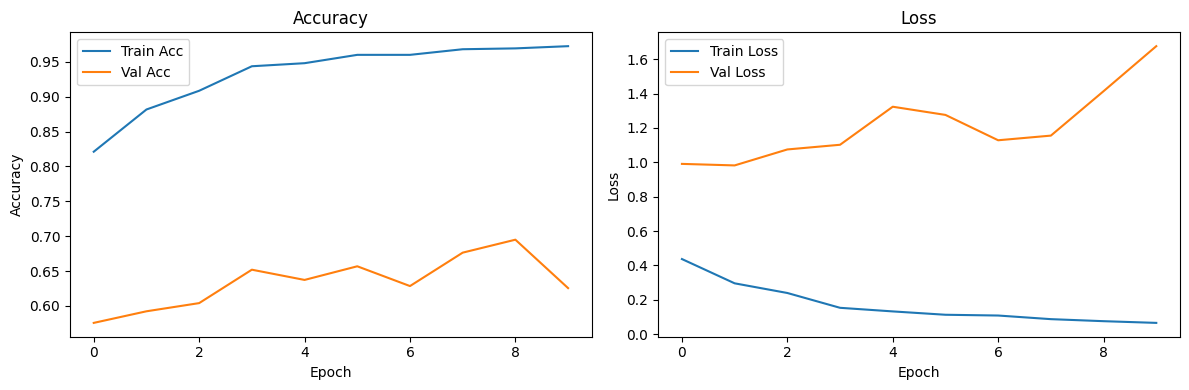

In [ ]:
# STEP 11: Plot accuracy/loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

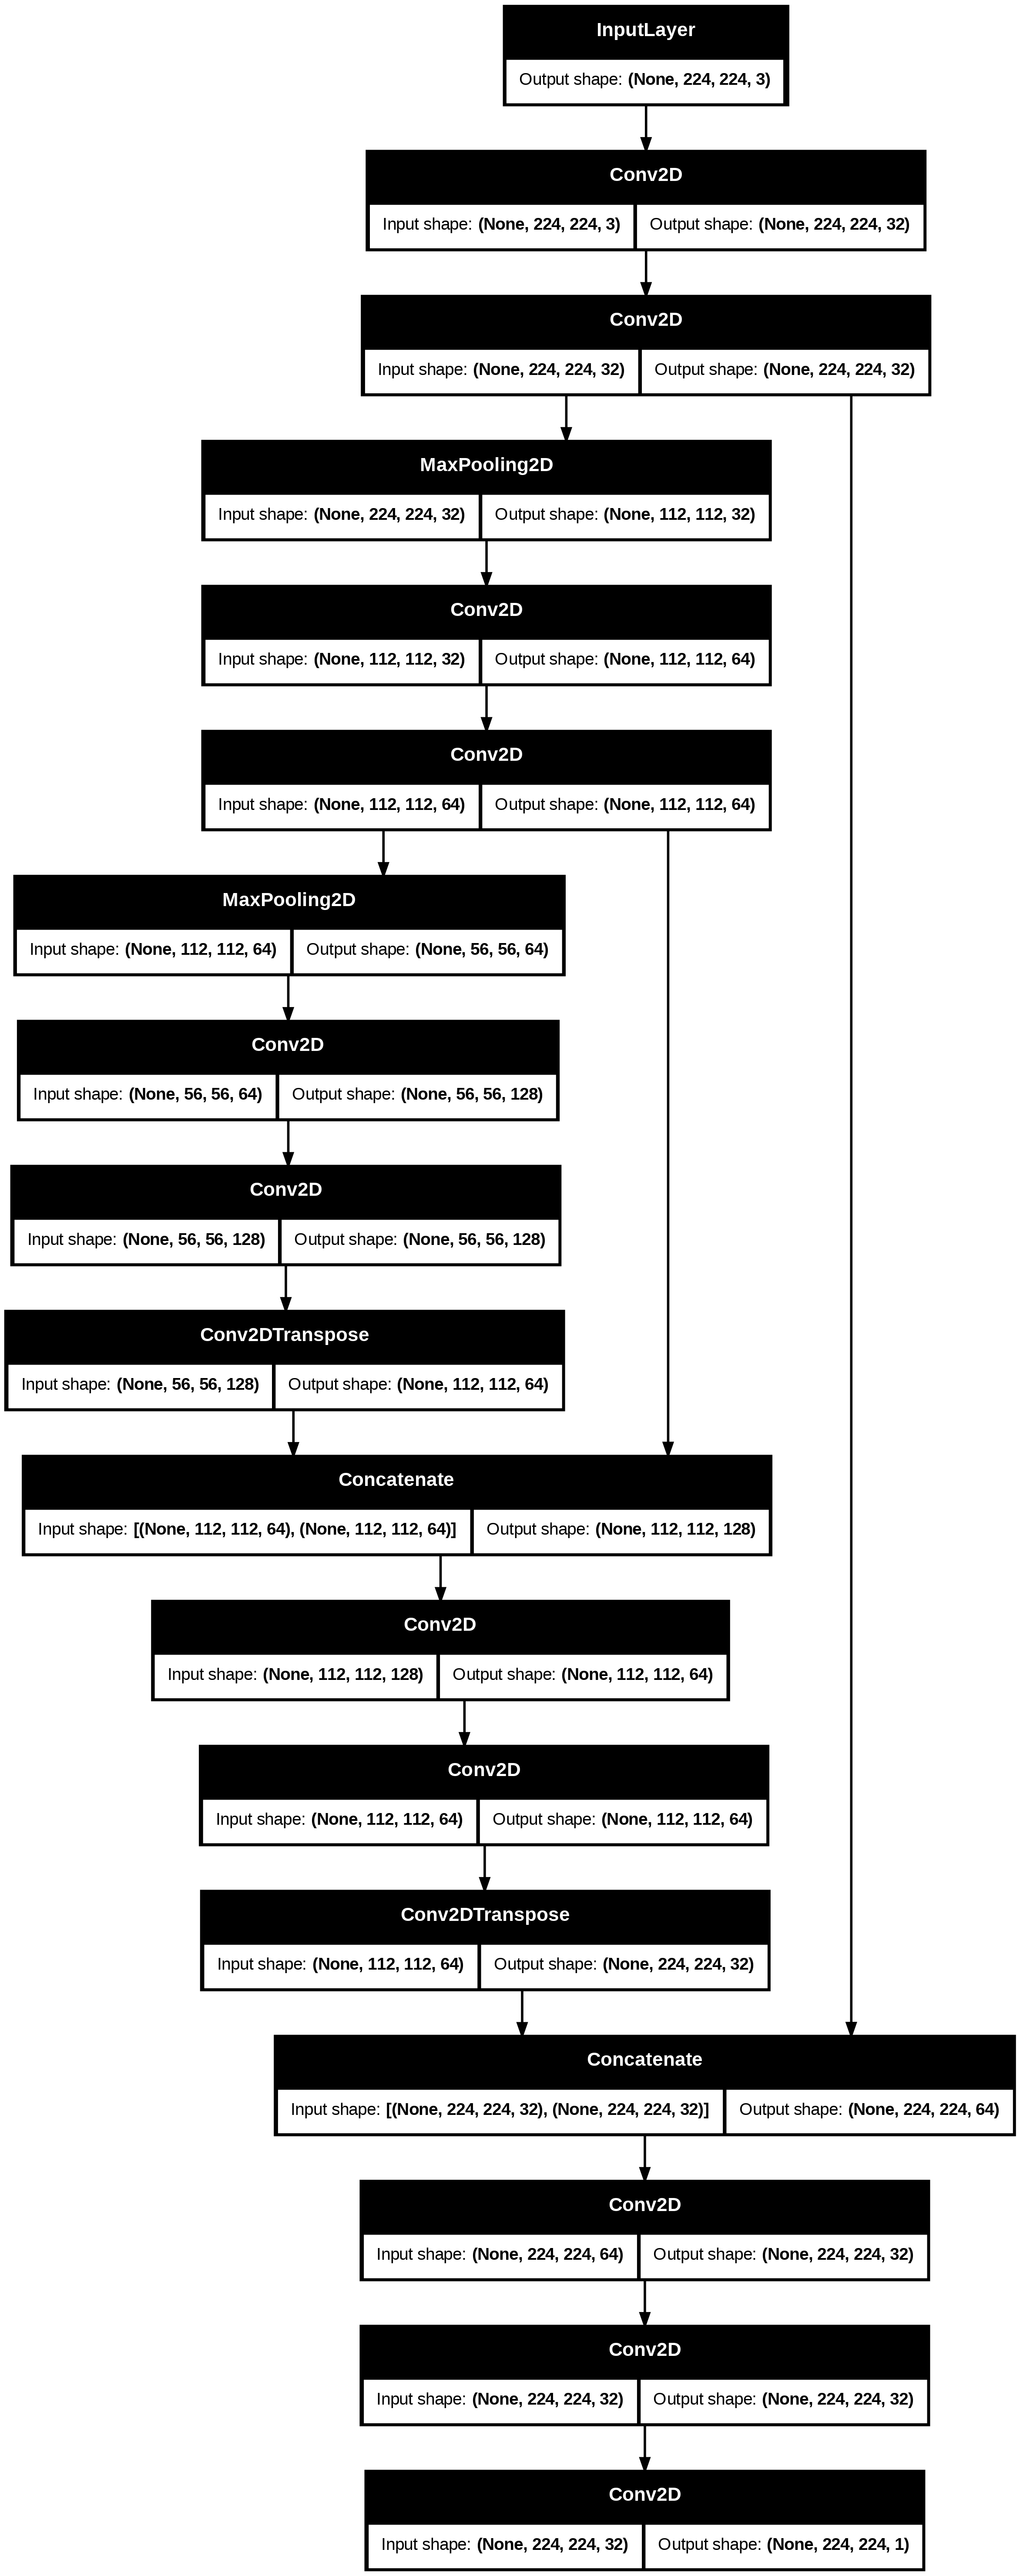

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# U-Net Architecture
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Encoder (Contracting Path)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decoder (Expansive Path)
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs=[inputs], outputs=[outputs])

# Initialize and compile model
model = build_unet()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# Visualize architecture
plot_model(model, show_shapes=True, to_file='unet_architecture.png')

In [ ]:
# Calculate hippocampal atrophy ratio from segmentation mask
def calculate_atrophy_ratio(mask):
    total_voxels = np.prod(mask.shape)
    lesion_voxels = np.sum(mask > 0.5)
    return (lesion_voxels / total_voxels) * 100

# Detect abnormal ventricular expansion
def detect_ventricular_expansion(mask, threshold=0.15):
    vent_ratio = calculate_atrophy_ratio(mask)
    return vent_ratio > threshold

def build_face_segmentation_unet():
    inputs = Input((256, 256, 3))

    # Encoder with pretrained weights
    base = tf.keras.applications.MobileNetV2(input_tensor=inputs, include_top=False)
    skip_connections = [base.get_layer(f'block_{i}_expand_relu').output
                       for i in [1, 3, 6]]

    # Decoder with face-specific features
    x = base.output
    for i, skip in enumerate(reversed(skip_connections)):
        x = Conv2DTranspose(64//2**i, (3,3), strides=2, padding='same')(x)
        x = concatenate([x, skip])
        x = Conv2D(64//2**i, (3,3), activation='relu', padding='same')(x)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(x)  # Face mask

    return Model(inputs, outputs)

def build_multi_feature_detector():
    # Shared encoder
    inputs = Input((224, 224, 3))
    base = tf.keras.applications.EfficientNetB0(input_tensor=inputs, include_top=False)

    # Multi-head output
    landmarks = Conv2D(10, (1,1), activation='sigmoid', name='landmarks')(base.output)
    pathologies = Conv2D(5, (1,1), activation='sigmoid', name='pathologies')(base.output)

    return Model(inputs, [landmarks, pathologies])


# Convert segmentation model to object detector
def create_detection_model(segmentation_model):
    # Freeze encoder
    for layer in segmentation_model.layers:
        if 'conv2d_transpose' not in layer.name:
            layer.trainable = False

    # Add detection head
    x = segmentation_model.layers[-2].output
    x = Conv2D(64, (3,3), activation='relu')(x)
    bbox = Conv2D(4, (1,1), activation='linear', name='bbox')(x)
    class_out = Conv2D(num_classes, (1,1), activation='softmax', name='class')(x)

    return Model(segmentation_model.input, [bbox, class_out])


# End-to-end clinical analysis workflow
def analyze_mri_scan(image_path):
    # 1. Preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])

    # 2. Segmentation
    mask = model.predict(tf.expand_dims(img, 0))

    # 3. Quantitative analysis
    atrophy = calculate_atrophy_ratio(mask)
    vent_expansion = detect_ventricular_expansion(mask)

    # 4. Generate report
    return {
        'atrophy_percentage': float(atrophy),
        'ventricular_abnormality': bool(vent_expansion),
        'visualization': generate_overlay(img, mask)
    }